In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
from scipy import stats 
import matplotlib.font_manager as fm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor



k_fold = KFold(n_splits=10,shuffle=True,random_state=0)


%matplotlib inline 

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)


plt.style.use('ggplot')

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])

train['year']=train['datetime'].dt.year
train['month']=train['datetime'].dt.month
train['hour']=train['datetime'].dt.hour
train['dayofweek']=train['datetime'].dt.dayofweek
train.shape


(10886, 16)

In [3]:
train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,4,5
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,5,5
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,2011,1,6,5
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,2011,1,7,5
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2011,1,8,5
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,2011,1,9,5


In [4]:
test['year']=test['datetime'].dt.year
test['month']=test['datetime'].dt.month
test['hour']=test['datetime'].dt.hour
test['dayofweek']=test['datetime'].dt.dayofweek
test.shape

(6493, 13)

In [5]:
categorical_feature_names = ['season','holiday','workingday','weather','dayofweek','month','year','hour']


for var in categorical_feature_names:
    train[var] =train[var].astype('category')
    test[var] =test[var].astype('category')

In [6]:
feature_names = ['season','holiday','windspeed','temp','atemp','humidity','workingday','weather','dayofweek','year','hour']

feature_names

['season',
 'holiday',
 'windspeed',
 'temp',
 'atemp',
 'humidity',
 'workingday',
 'weather',
 'dayofweek',
 'year',
 'hour']

In [7]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,holiday,windspeed,temp,atemp,humidity,workingday,weather,dayofweek,year,hour
0,1,0,0.0,9.84,14.395,81,0,1,5,2011,0
1,1,0,0.0,9.02,13.635,80,0,1,5,2011,1
2,1,0,0.0,9.02,13.635,80,0,1,5,2011,2
3,1,0,0.0,9.84,14.395,75,0,1,5,2011,3
4,1,0,0.0,9.84,14.395,75,0,1,5,2011,4


In [8]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,holiday,windspeed,temp,atemp,humidity,workingday,weather,dayofweek,year,hour
0,1,0,26.0027,10.66,11.365,56,1,1,3,2011,0
1,1,0,0.0000,10.66,13.635,56,1,1,3,2011,1
2,1,0,0.0000,10.66,13.635,56,1,1,3,2011,2
3,1,0,11.0014,10.66,12.880,56,1,1,3,2011,3
4,1,0,11.0014,10.66,12.880,56,1,1,3,2011,4


In [9]:
label_name ='count'

y_train = train[label_name]

print(y_train.shape)
y_train.head(10)


(10886,)


0    16
1    40
2    32
3    13
4     1
5     1
6     2
7     3
8     8
9    14
Name: count, dtype: int64

In [10]:
def rmsle(predicted_values, actual_values,convertExp=True):
    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

# 선형회귀모델링  Linear Regression Model
* 선형회귀는 매개변수가 없는것이 장점이나, 동시에 모델의 복잡도를 제어할 수 없는것이 단점

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
pd.options.mode.chained_assignment = None

# 선형회귀모델 초기화
lModel = LinearRegression()

# 모델 학습
y_train_log = np.log1p(y_train)
lModel.fit(X_train,y_train_log)

# 예측하고 정확도 평가
preds = lModel.predict(X_train)
print('RMSLE Value For Linear Regression : ',rmsle(np.exp(y_train_log),np.exp(preds),False))




RMSLE Value For Linear Regression :  0.9796533446288495


# 릿지 모델 Regularization Model - Ridge
* 회귀를 위한 선형모델
* 가중치 (w) 의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화
* Regularization(규제) 는 오버피팅되지 않도록 모델을 강제제한 한다는 의미
* Max_iter(최대 반복 횟수) 는 3000을 넣어주었음


In [12]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# 주어진  alpha 중 최적의 alpha 를 GridSearch 를 통채 찾아내기
grid_ridge_m = GridSearchCV( ridge_m_,ridge_params_,scoring = rmsle_scorer,cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9796533426169115


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004204,4.004002e-04,0.002002,1.507891e-07,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.002580,-0.905357,-1.031529,-1.014918,-0.983504,-0.987578,0.044002,1
1,0.004004,6.329375e-04,0.001401,4.904854e-04,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.002583,-0.905357,-1.031529,-1.014917,-0.983506,-0.987578,0.044003,2
2,0.004004,6.330129e-04,0.002002,1.907349e-07,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.002611,-0.905357,-1.031526,-1.014909,-0.983519,-0.987584,0.044003,3
3,0.004004,2.611745e-07,0.001802,4.002333e-04,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.002641,-0.905356,-1.031523,-1.014900,-0.983534,-0.987591,0.044003,4
4,0.003803,4.003048e-04,0.001601,4.903297e-04,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.002672,-0.905355,-1.031520,-1.014891,-0.983549,-0.987598,0.044003,5


# 라쏘 Reagularization Model - Lasso
* 선형 회귀의 규제를 적용하는 대안
* 계수를 0 에 가깝게 만들려고 하며, 이를 L1 규제라고 하며, 어떤 계수는 0 이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
* 피처 선택이 자동으로 이루어진다고도 볼 수 있음
* 알파값의 기본값은 1.0 이며, 과소적합을 줄이기 위해서는 이 값을 줄여야한다.
* 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
* Max_iter(최대 반복횟수) 는 3000을 넣었음

In [13]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.0025, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9796675216165436


,alpha,rmsle
0,10.000000,1.397124
1,1.000000,1.071947
2,0.500000,1.062110
3,0.333333,1.060815
4,0.250000,1.061180


In [14]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10638297667413162


C:\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

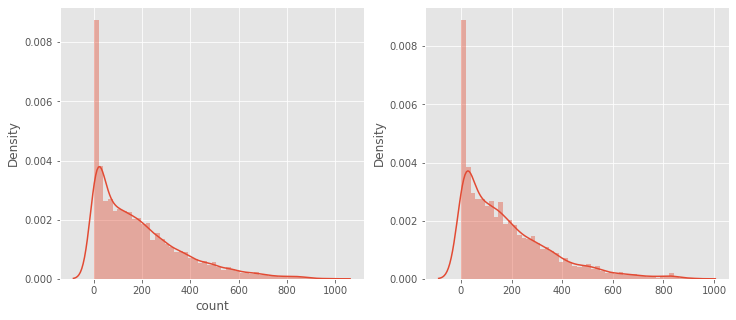

In [15]:
predsTest = rfModel.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

## 앙상블모델 - 그라디언트 부스트
### Ensemble Model - Gradient Boost
* 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있음
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
* 무작위성이 없고 강력한 사전 가지치기가 사용 됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
* learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
* max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.2041726289560153


In [17]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

submission.to_csv(f"data/Score_{score:.5f}_submission.csv", index=False)

(6493, 2)
